In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [ ]:
# Mounting the drive is straightforward but requires authentication each 
# time we reset the session
drive.mount('/content/drive')
drive_path = '/content/drive/Shareddrives/Capstone_Vacancy/data/'


Mounted at /content/drive


Let's look at the different data sets we have:

In [ ]:
! ls /content/drive/Shareddrives/Capstone_Vacancy/data

cleaned			meterWaterFlow.csv	securityUniqueDaily.csv
co2Sensor.csv		modelData		securityUniqueHourly.csv
freezers		occSensors		soundLevelSensor.csv
fumehoodFlow.csv	occSensorZone.csv	tvocSensor.csv
lighting.csv		securityCardEvents.csv	wifi_ap_data.csv
lightingOccSensors.csv	securityDaily.csv


And cleaned data:

In [ ]:
! ls /content/drive/Shareddrives/Capstone_Vacancy/data/cleaned

co2Sensors.csv		securityDailyAll.csv	  soundLevelSensor.csv
co2Sensors.pkl		securityDailyAll.pkl	  soundLevelSensor.pkl
freezers.csv		securityDailyUnique.csv   tvocSensors.csv
freezers.pkl		securityDailyUnique.pkl   tvocSensors.pkl
fumehoodFlow.csv	securityEvents.csv	  waterMeter.csv
fumehoodFlow.pkl	securityEvents.pkl	  waterMeter.pkl
lightingOccSensors.csv	securityHourlyUnique.csv  wifi_ap_data.csv
lightingOccSensors.pkl	securityHourlyUnique.pkl  wifi_ap_data.pkl


# Goal
We can try to use the following to engineer an "occupied" flag:


*   co2sensors
*   freezers
*   fumehoodFlow
*   lightingOccSensors
*   securityDailyAll
*   securityDailyUnique
*   securityEvents
*   securityHourlyUnique
*   soundLevelSensor
*   tvocSensors
*   waterMeter



# co2sensors

**For this one we need to get the outside co2 data so we can subtract inside co2 for a meaningful metric. Chris is looking into this.**

CO2 has a lag for occupancy, so it's not good for determining the beginning of occupancy. 

May be good to pick a higher derivative.

In [ ]:
co2df = pd.read_pickle(drive_path + 'cleaned/' + 'co2Sensors.pkl')
co2df

Floor,2,1,3,4
Room,244,125,384,481
ts,,,,
2020-12-09 16:30:00-08:00,NaN,421.0,NaN,NaN
2020-12-09 16:35:00-08:00,NaN,420.8,NaN,NaN
2020-12-09 16:40:00-08:00,NaN,421.6,NaN,NaN
2020-12-09 16:45:00-08:00,NaN,419.4,NaN,NaN
2020-12-09 16:50:00-08:00,NaN,419.2,NaN,NaN
...,...,...,...,...
2021-05-07 10:10:00-07:00,352.2,376.0,450.2,595.0
2021-05-07 10:15:00-07:00,350.8,377.0,452.0,596.2


<Figure size 432x288 with 0 Axes>

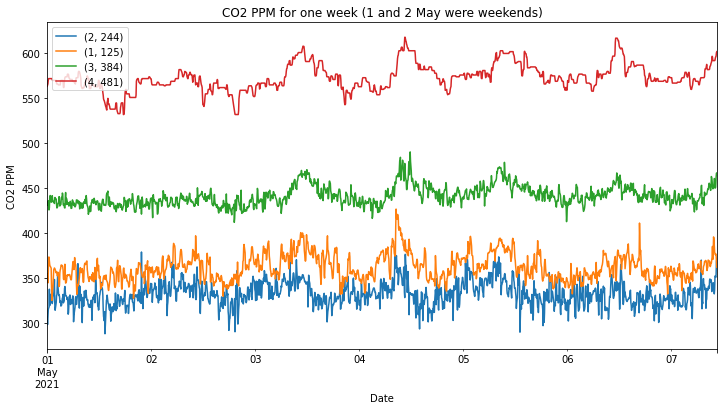

In [ ]:
plt.figure(); co2df['2021-05-01':'2021-05-07'].plot(figsize=(12,6)); plt.legend(loc='best') 
plt.xlabel("Date"); plt.ylabel("CO2 PPM"); plt.title("CO2 PPM for one week (1 and 2 May were weekends)") 
plt.show()

Try making an exponential weighted average and count as occupied when the CO2 levels are increasing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<Figure size 432x288 with 0 Axes>

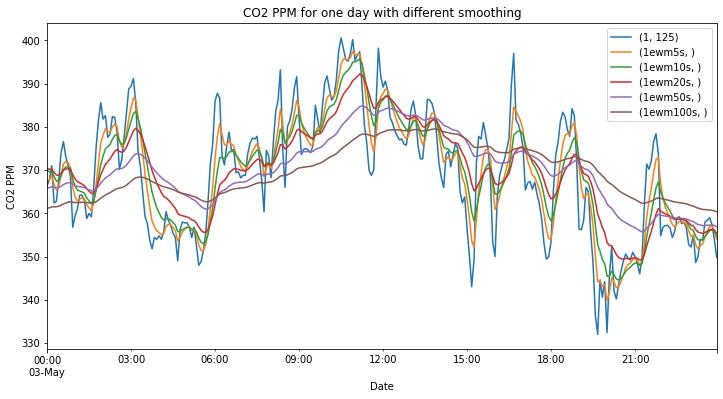

In [ ]:
# take a subset to experiment with
input_data = co2df[['1']]

# Try different smoothings
input_data['1ewm5s'] = input_data['1'].ewm(span = 5).mean()
input_data['1ewm10s'] = input_data['1'].ewm(span = 10).mean()
input_data['1ewm20s'] = input_data['1'].ewm(span = 20).mean()
input_data['1ewm50s'] = input_data['1'].ewm(span = 50).mean()
input_data['1ewm100s'] = input_data['1'].ewm(span = 100).mean()

plt.figure(); input_data['2021-05-03'].plot(figsize=(12,6)); plt.legend(loc='best') 
plt.xlabel("Date"); plt.ylabel("CO2 PPM"); plt.title("CO2 PPM for one day with different smoothing") 
plt.show()



Span = 100 seems like a good smoother. Now we need the slope of this line. If the co2 rates are INCREASING, it's a good indicator that someone is in the room.

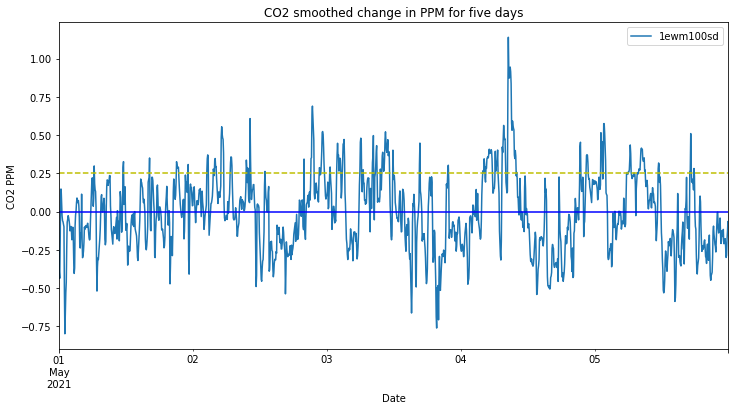

In [ ]:
input_data['1ewm100sd'] = input_data['1ewm100s'].diff()
input_data

plt.figure(); input_data['1ewm100sd']['2021-05-01':'2021-05-05'].plot(figsize=(12,6)); plt.legend(loc='best') 
plt.xlabel("Date"); plt.ylabel("CO2 PPM"); plt.title("CO2 smoothed change in PPM for five days") 
plt.axhline(y=0, color='b', linestyle='-')
plt.axhline(y=.25, color='y', linestyle='--')
plt.show()

We can play with where we set the cutoff for the slope for different levels of certainty.

In [ ]:
def label_occ(row, cutoff):
  if row['1ewm100sd'].item() > cutoff :
    return 1
  else:
    return 0

input_data['occ_co2_1_0'] = input_data.apply(lambda row: label_occ(row, 0), axis=1)
input_data['occ_co2_1_025'] = input_data.apply(lambda row: label_occ(row, 0.25), axis=1)
input_data

Floor,1,1ewm5s,1ewm10s,1ewm20s,1ewm50s,1ewm100s,1ewm100sd,occ_co2_1_0,occ_co2_1_025
Room,125,,,,,,,,
ts,,,,,,,,,
2020-12-09 16:30:00-08:00,421.0,421.000000,421.000000,421.000000,421.000000,421.000000,NaN,0,0
2020-12-09 16:35:00-08:00,420.8,420.880000,420.890000,420.895000,420.898000,420.899000,-0.101000,0,0
2020-12-09 16:40:00-08:00,421.6,421.221053,421.175415,421.153872,421.141421,421.137355,0.238355,1,0
2020-12-09 16:45:00-08:00,419.4,420.464615,420.590495,420.647556,420.679603,420.689900,-0.447455,0,0
2020-12-09 16:50:00-08:00,419.2,419.979147,420.191322,420.297405,420.359545,420.379883,-0.310017,0,0
...,...,...,...,...,...,...,...,...,...
2021-05-07 10:10:00-07:00,376.0,379.570483,379.145200,375.700729,369.128190,364.165094,0.239089,1,0
2021-05-07 10:15:00-07:00,377.0,378.713655,378.755164,375.824469,369.436889,364.419251,0.254157,1,1


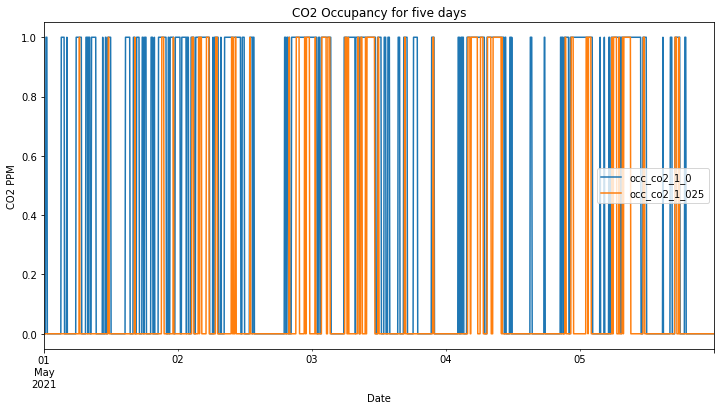

In [ ]:
plt.figure()
input_data['occ_co2_1_0']['2021-05-01':'2021-05-05'].plot(figsize=(12,6))
input_data['occ_co2_1_025']['2021-05-01':'2021-05-05'].plot(figsize=(12,6))
plt.legend(loc='best') 
plt.xlabel("Date"); plt.ylabel("CO2 PPM"); plt.title("CO2 Occupancy for five days") 
plt.show()

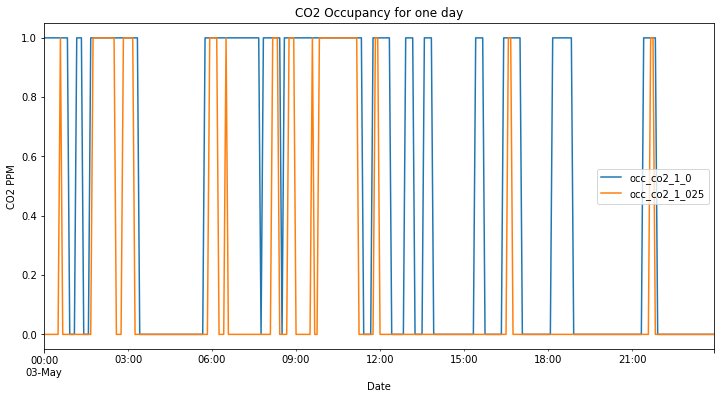

In [ ]:
plt.figure()
input_data['occ_co2_1_0']['2021-05-03'].plot(figsize=(12,6))
input_data['occ_co2_1_025']['2021-05-03'].plot(figsize=(12,6))
plt.legend(loc='best') 
plt.xlabel("Date"); plt.ylabel("CO2 PPM"); plt.title("CO2 Occupancy for one day") 
plt.show()

# freezers

In [ ]:
fredf = pd.read_pickle(drive_path + 'cleaned/' + 'freezers.pkl')
fredf

Floor                       1       2   1   2   1  ...   2                   1
Room                      130     230 130 230 130  ... 230                 149
Freezer                    14  08  06  10  09  38  ...  20  40  25  13  33  10
ts                                                 ...                        
2020-05-06 14:40:57-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2020-05-06 14:45:20-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2020-05-06 14:45:31-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2020-05-06 22:39:41-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2020-05-06 22:51:20-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
...                        ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..
2021-05-05 18:31:07-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2021-05-05 18:36:44-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2021-05-05 18:36:54-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2021-05-05 18:45:29-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2021-05-05 18:45:50-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN

[129500 rows x 61 columns]

Text(0, 0.5, 'Count of door open events')

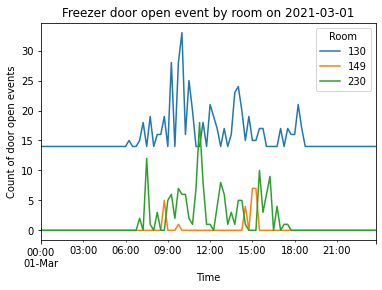

In [ ]:
fredf['2021-03-01'].groupby(by="Room", axis=1).count().resample('15min').sum().plot()
plt.title('Freezer door open event by room on 2021-03-01')
plt.xlabel('Time')
plt.ylabel('Count of door open events')

To engineer this feature at the room level:

*   Group freezers by room
*   Smooth door open events to eliminate artifact generated by sampling frequency mismatch
*   Get a rate of change to tell when people are there opening doors. (some doors remain open so have to control for that.) 



In [ ]:
roomcount = fredf.groupby(by="Room", axis=1).count().resample('5min').sum()
roomcount

Room,130,149,230
ts,,,
2020-05-06 14:40:00-07:00,0,0,1
2020-05-06 14:45:00-07:00,0,0,2
2020-05-06 14:50:00-07:00,0,0,0
2020-05-06 14:55:00-07:00,0,0,0
2020-05-06 15:00:00-07:00,0,0,0
...,...,...,...
2021-05-05 18:25:00-07:00,2,0,0
2021-05-05 18:30:00-07:00,2,0,0
2021-05-05 18:35:00-07:00,2,0,0


In [ ]:
roomsmooth = roomcount.ewm(span = 5).mean()
roomsmooth

Room,130,149,230
ts,,,
2020-05-06 14:40:00-07:00,0.000000,0.000000e+00,1.000000
2020-05-06 14:45:00-07:00,0.000000,0.000000e+00,1.600000
2020-05-06 14:50:00-07:00,0.000000,0.000000e+00,0.842105
2020-05-06 14:55:00-07:00,0.000000,0.000000e+00,0.492308
2020-05-06 15:00:00-07:00,0.000000,0.000000e+00,0.303318
...,...,...,...
2021-05-05 18:25:00-07:00,0.931875,3.883157e-58,0.205972
2021-05-05 18:30:00-07:00,1.287917,2.588772e-58,0.137315
2021-05-05 18:35:00-07:00,1.525278,1.725848e-58,0.091543


In [ ]:
roomchange = roomsmooth.diff()

# where the rate of change is not zero, we have occupancy
roomchange['130oc'] = np.where(abs(roomchange['130']) > 0.5, 1, 0)
roomchange['149oc'] = np.where(abs(roomchange['149']) > 0.5, 1, 0)
roomchange['230oc'] = np.where(abs(roomchange['230']) > 0.5, 1, 0)

fre_oc = roomchange[['130oc', '149oc', '230oc']]
fre_oc

Room,130oc,149oc,230oc
ts,,,
2020-05-06 14:40:00-07:00,0,0,0
2020-05-06 14:45:00-07:00,0,0,1
2020-05-06 14:50:00-07:00,0,0,1
2020-05-06 14:55:00-07:00,0,0,0
2020-05-06 15:00:00-07:00,0,0,0
...,...,...,...
2021-05-05 18:25:00-07:00,1,0,0
2021-05-05 18:30:00-07:00,0,0,0
2021-05-05 18:35:00-07:00,0,0,0


Text(0, 0.5, 'Occupancy Flag')

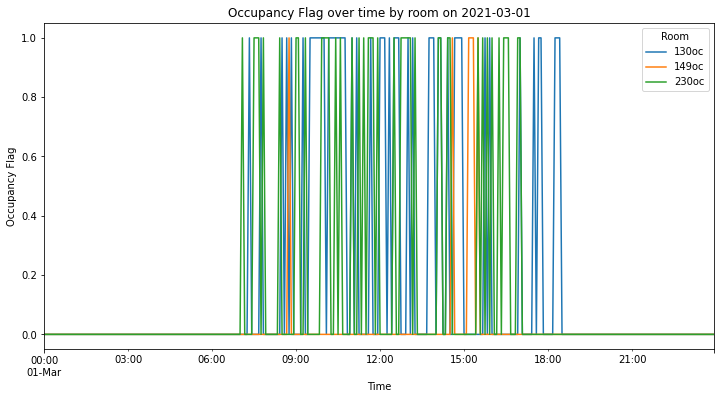

In [ ]:
fre_oc['2021-03-01'].plot(figsize=(12,6))
plt.title('Occupancy Flag over time by room on 2021-03-01')
plt.xlabel('Time')
plt.ylabel('Occupancy Flag')

In [ ]:
fre_oc.to_csv(path_or_buf = drive_path + 'modelData/' + 'freezers_occ.csv')

# fumehoodFlow

In [ ]:
fumdf = pd.read_pickle(drive_path + 'cleaned/' + 'fumehoodFlow.pkl')
fumdf

Floor                         2                    1         ...   2   1   2       1
Room                        225           244    145    125  ... 225 145 244 245 145
Fumehood                     81     80     93     68     56  ...  81  68  93  94  67
ts                                                           ...                    
2020-05-07 00:00:00-07:00  15.0  157.0  815.0  141.0  304.0  ... NaN NaN NaN NaN NaN
2020-05-07 00:10:00-07:00  15.0  154.0  818.0  149.0  300.0  ... NaN NaN NaN NaN NaN
2020-05-07 00:20:00-07:00  15.0  152.0  809.0  134.0  307.0  ... NaN NaN NaN NaN NaN
2020-05-07 00:30:00-07:00  15.0  153.0  814.0  135.0  302.0  ... NaN NaN NaN NaN NaN
2020-05-07 00:40:00-07:00  15.0  151.0  821.0  144.0  298.0  ... NaN NaN NaN NaN NaN
...                         ...    ...    ...    ...    ...  ...  ..  ..  ..  ..  ..
2021-05-07 13:10:00-07:00  85.0   91.0  247.0   82.0  553.0  ... NaN NaN NaN NaN NaN
2021-05-07 13:20:00-07:00   NaN   86.0    NaN   79.0  561.0  ... NaN NaN NaN NaN NaN
2021-05-07 13:30:00-07:00   NaN    NaN    NaN    NaN    NaN  ... NaN NaN NaN NaN NaN
2021-05-07 13:40:00-07:00   NaN    NaN    NaN    NaN    NaN  ... NaN NaN NaN NaN NaN
2021-05-07 13:50:00-07:00   NaN    NaN    NaN    NaN    NaN  ... NaN NaN NaN NaN NaN

[51932 rows x 27 columns]

Text(0, 0.5, 'Air Flow (cfm)')

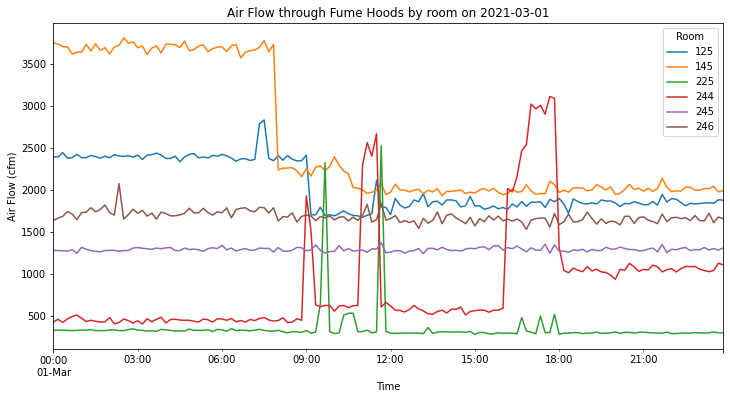

In [ ]:
fumdf['2021-03-01'].groupby(by="Room", axis=1).sum().plot(figsize=(12,6))
plt.title('Air Flow through Fume Hoods by room on 2021-03-01')
plt.xlabel('Time')
plt.ylabel('Air Flow (cfm)')

In [ ]:
# working with a subset for speed
roomcount = fumdf.groupby(by="Room", axis=1).sum()
roomcount


Room,125,145,225,244,245,246
ts,,,,,,
2020-05-07 00:00:00-07:00,966.0,580.0,344.0,1630.0,320.0,1748.0
2020-05-07 00:10:00-07:00,958.0,570.0,338.0,1636.0,306.0,1724.0
2020-05-07 00:20:00-07:00,968.0,556.0,334.0,1618.0,318.0,1706.0
2020-05-07 00:30:00-07:00,958.0,560.0,336.0,1628.0,312.0,1736.0
2020-05-07 00:40:00-07:00,954.0,568.0,332.0,1642.0,312.0,1724.0
...,...,...,...,...,...,...
2021-05-07 13:10:00-07:00,2436.0,654.0,352.0,494.0,846.0,624.0
2021-05-07 13:20:00-07:00,1766.0,427.0,187.0,272.0,410.0,312.0
2021-05-07 13:30:00-07:00,1215.0,332.0,84.0,259.0,408.0,319.0


In [ ]:
roomdiff = roomcount.diff()
roomdiff['125oc'] = np.where(abs(roomdiff['125']) > 175, 1, 0)
roomdiff['145oc'] = np.where(abs(roomdiff['145']) > 175, 1, 0)
roomdiff['225oc'] = np.where(abs(roomdiff['225']) > 175, 1, 0)
roomdiff['244oc'] = np.where(abs(roomdiff['244']) > 175, 1, 0)
roomdiff['245oc'] = np.where(abs(roomdiff['245']) > 175, 1, 0)
roomdiff['246oc'] = np.where(abs(roomdiff['246']) > 175, 1, 0)
roomdiff

Room,125,145,225,244,245,246,125oc,145oc,225oc,244oc,245oc,246oc
ts,,,,,,,,,,,,
2020-05-07 00:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2020-05-07 00:10:00-07:00,-8.0,-10.0,-6.0,6.0,-14.0,-24.0,0,0,0,0,0,0
2020-05-07 00:20:00-07:00,10.0,-14.0,-4.0,-18.0,12.0,-18.0,0,0,0,0,0,0
2020-05-07 00:30:00-07:00,-10.0,4.0,2.0,10.0,-6.0,30.0,0,0,0,0,0,0
2020-05-07 00:40:00-07:00,-4.0,8.0,-4.0,14.0,0.0,-12.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 13:10:00-07:00,0.0,-8.0,138.0,-26.0,2.0,6.0,0,0,0,0,0,0
2021-05-07 13:20:00-07:00,-670.0,-227.0,-165.0,-222.0,-436.0,-312.0,1,1,0,1,1,1
2021-05-07 13:30:00-07:00,-551.0,-95.0,-103.0,-13.0,-2.0,7.0,1,0,0,0,0,0


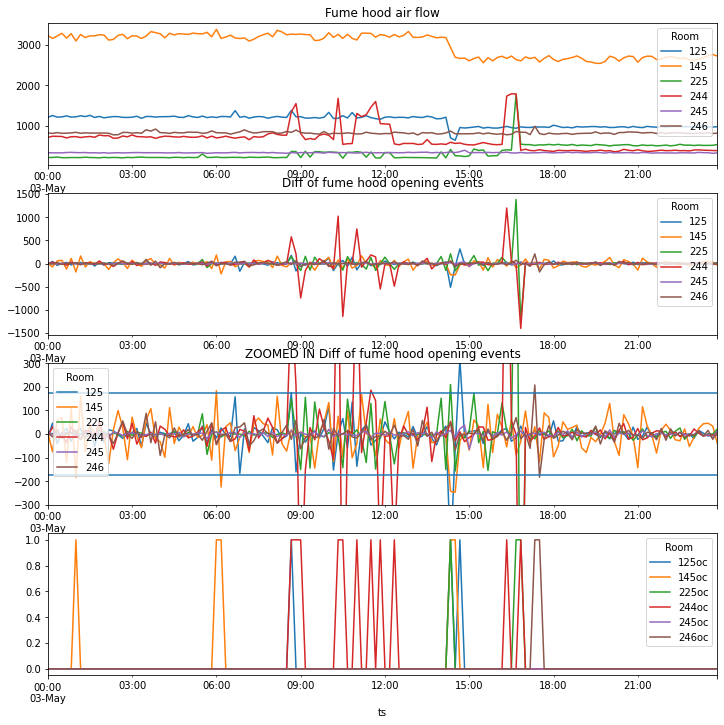

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1)
fumdf['2021-05-03'].groupby(by="Room", axis=1).sum().plot(ax=axes[0],figsize=(12,12)); 
axes[0].set_title('Fume hood air flow')
roomdiff['2021-05-03'].iloc[:,0:6].groupby(by="Room", axis=1).sum().plot(ax=axes[1]); 
axes[1].set_title('Diff of fume hood opening events')
roomdiff['2021-05-03'].iloc[:,0:6].groupby(by="Room", axis=1).sum().plot(ax=axes[2]); 
axes[2].set_title('ZOOMED IN Diff of fume hood opening events')
axes[2].set_ylim(-300,300); axes[2].axhline(175); axes[2].axhline(-175)
roomdiff['2021-05-03'].iloc[:,6:12].plot(ax=axes[3]);

In [ ]:
fhocdf = roomdiff.iloc[:,6:12].resample('5min').interpolate(method='nearest')
fhocdf

Room,125oc,145oc,225oc,244oc,245oc,246oc
ts,,,,,,
2020-05-07 00:00:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-07 00:05:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-07 00:10:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-07 00:15:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-07 00:20:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2021-05-07 13:30:00-07:00,1.0,0.0,0.0,0.0,0.0,0.0
2021-05-07 13:35:00-07:00,1.0,0.0,0.0,0.0,0.0,0.0
2021-05-07 13:40:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
fhocdf.to_csv(path_or_buf = drive_path + 'modelData/' + 'fumehoodFlow_occ.csv')

# lightingOccSensors

In [ ]:
occsdf = pd.read_pickle(drive_path + 'cleaned/' + 'lightingOccSensors.pkl')
occsdf

Floor                                                    1  ...                          4
Room                                                   145  ...                        437
Sensor                                           006C-FCC2  ...                  0080-FFF3
Tag                       145 Open Lab OCS 008 [006C-FCC2]  ... 437 Office OCS [0080-FFF3]
ts                                                          ...                           
2020-07-07 12:20:00+00:00                              NaN  ...                        NaN
2020-07-07 12:25:00+00:00                              NaN  ...                        NaN
2020-07-07 12:30:00+00:00                              NaN  ...                        NaN
2020-07-07 12:35:00+00:00                              NaN  ...                        NaN
2020-07-07 12:40:00+00:00                              NaN  ...                        0.0
...                                                    ...  ...                        ...
2021-05-06 09:05:00+00:00                              1.0  ...                        NaN
2021-05-06 09:10:00+00:00                              1.0  ...                        0.0
2021-05-06 09:15:00+00:00                              1.0  ...                        NaN
2021-05-06 09:20:00+00:00                              NaN  ...                        NaN
2021-05-06 09:25:00+00:00                              NaN  ...                        NaN

[87230 rows x 287 columns]

Text(0, 0.5, 'Motion events detected')

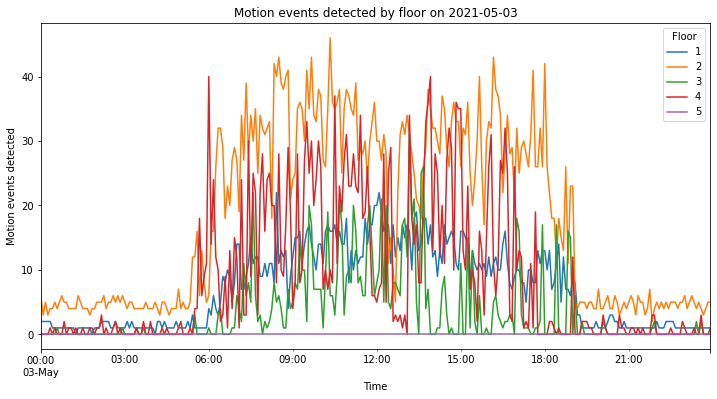

In [ ]:
occsdf['2021-05-03'].groupby(by="Floor", axis=1).sum().plot(figsize=(12,6))
plt.title('Motion events detected by floor on 2021-05-03')
plt.xlabel('Time')
plt.ylabel('Motion events detected')

In [ ]:
floorcount = occsdf.groupby(by="Floor", axis=1).sum()
floorcount

Floor,1,2,3,4,5
ts,,,,,
2020-07-07 12:20:00+00:00,0.0,16.0,0.0,0.0,0.0
2020-07-07 12:25:00+00:00,0.0,9.0,0.0,0.0,0.0
2020-07-07 12:30:00+00:00,0.0,11.0,0.0,0.0,0.0
2020-07-07 12:35:00+00:00,0.0,6.0,0.0,0.0,0.0
2020-07-07 12:40:00+00:00,0.0,8.0,8.0,30.0,0.0
...,...,...,...,...,...
2021-05-06 09:05:00+00:00,20.0,43.0,1.0,17.0,0.0
2021-05-06 09:10:00+00:00,20.0,40.0,1.0,5.0,0.0
2021-05-06 09:15:00+00:00,18.0,37.0,1.0,1.0,0.0


In [ ]:
floordiff = floorcount.diff()

# set up occupancy flag limits
floordiff['1oc'] = np.where(abs(floordiff['1']) > 3.5, 1, 0)
floordiff['2oc'] = np.where(abs(floordiff['2']) > 3.5, 1, 0)
floordiff['3oc'] = np.where(abs(floordiff['3']) > 3.5, 1, 0)
floordiff['4oc'] = np.where(abs(floordiff['4']) > 3.5, 1, 0)
floordiff['5oc'] = np.where(abs(floordiff['5']) > 3.5, 1, 0)
floordiff

Floor,1,2,3,4,5,1oc,2oc,3oc,4oc,5oc
ts,,,,,,,,,,
2020-07-07 12:20:00+00:00,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2020-07-07 12:25:00+00:00,0.0,-7.0,0.0,0.0,0.0,0,1,0,0,0
2020-07-07 12:30:00+00:00,0.0,2.0,0.0,0.0,0.0,0,0,0,0,0
2020-07-07 12:35:00+00:00,0.0,-5.0,0.0,0.0,0.0,0,1,0,0,0
2020-07-07 12:40:00+00:00,0.0,2.0,8.0,30.0,0.0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
2021-05-06 09:05:00+00:00,4.0,8.0,0.0,-2.0,0.0,1,1,0,0,0
2021-05-06 09:10:00+00:00,0.0,-3.0,0.0,-12.0,0.0,0,0,0,1,0
2021-05-06 09:15:00+00:00,-2.0,-3.0,0.0,-4.0,0.0,0,0,0,1,0


Text(0.5, 1.0, 'Diff Detected occupancy sensor flag')

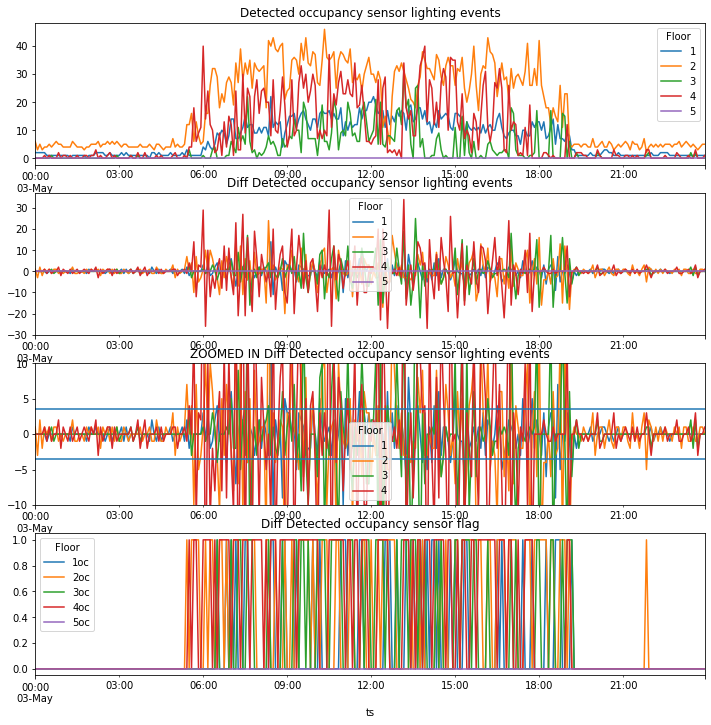

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1)
floorcount['2021-05-03'].plot(ax=axes[0],figsize=(12,12)); 
axes[0].set_title('Detected occupancy sensor lighting events')
floordiff['2021-05-03'].iloc[:,0:5].plot(ax=axes[1]); 
axes[1].set_title('Diff Detected occupancy sensor lighting events')
floordiff['2021-05-03'].iloc[:,0:4].plot(ax=axes[2]); 
axes[2].set_title('ZOOMED IN Diff Detected occupancy sensor lighting events')
axes[2].set_ylim(-10,10); axes[2].axhline(3.5); axes[2].axhline(-3.5)
floordiff['2021-05-03'].iloc[:,5:10].plot(ax=axes[3]); 
axes[3].set_title('Diff Detected occupancy sensor flag')

In [ ]:
liocdf = floordiff.iloc[:,5:10]
liocdf

Floor,1oc,2oc,3oc,4oc,5oc
ts,,,,,
2020-07-07 12:20:00+00:00,0,0,0,0,0
2020-07-07 12:25:00+00:00,0,1,0,0,0
2020-07-07 12:30:00+00:00,0,0,0,0,0
2020-07-07 12:35:00+00:00,0,1,0,0,0
2020-07-07 12:40:00+00:00,0,0,1,1,0
...,...,...,...,...,...
2021-05-06 09:05:00+00:00,1,1,0,0,0
2021-05-06 09:10:00+00:00,0,0,0,1,0
2021-05-06 09:15:00+00:00,0,0,0,1,0


In [ ]:
liocdf.to_csv(path_or_buf = drive_path + 'modelData/' + 'lightingOccSensors_occ.csv')

# soundLevelSensor

In [ ]:
soledf = pd.read_pickle(drive_path + 'cleaned/' + 'soundLevelSensor.pkl')
soledf

Floor,2,3,4,1
Room,244,384,481,125
ts,,,,
2020-12-21 10:50:00-08:00,52.0,64.4,58.0,63.0
2020-12-21 10:55:00-08:00,61.6,61.0,63.4,61.4
2020-12-21 11:00:00-08:00,76.0,60.2,67.0,61.0
2020-12-21 11:05:00-08:00,71.4,60.0,61.4,69.0
2020-12-21 11:10:00-08:00,53.0,57.6,53.0,71.0
...,...,...,...,...
2021-05-07 09:00:00-07:00,67.0,53.0,52.0,64.0
2021-05-07 09:05:00-07:00,67.0,53.0,52.0,64.0


In [ ]:
floordiff = soledf.diff()
# set up occupancy flag limits
floordiff['1oc'] = np.where(abs(floordiff['1']) > 1.5, 1, 0)
floordiff['2oc'] = np.where(abs(floordiff['2']) > 1.5, 1, 0)
floordiff['3oc'] = np.where(abs(floordiff['3']) > 1.5, 1, 0)
floordiff['4oc'] = np.where(abs(floordiff['4']) > 1.5, 1, 0)
floordiff

Floor,2,3,4,1,1oc,2oc,3oc,4oc
Room,244,384,481,125,,,,
ts,,,,,,,,
2020-12-21 10:50:00-08:00,NaN,NaN,NaN,NaN,0,0,0,0
2020-12-21 10:55:00-08:00,9.6,-3.4,5.4,-1.6,1,1,1,1
2020-12-21 11:00:00-08:00,14.4,-0.8,3.6,-0.4,0,1,0,1
2020-12-21 11:05:00-08:00,-4.6,-0.2,-5.6,8.0,1,1,0,1
2020-12-21 11:10:00-08:00,-18.4,-2.4,-8.4,2.0,1,1,1,1
...,...,...,...,...,...,...,...,...
2021-05-07 09:00:00-07:00,0.0,0.0,0.0,0.0,0,0,0,0
2021-05-07 09:05:00-07:00,0.0,0.0,0.0,0.0,0,0,0,0


Text(0.5, 1.0, 'Occupancy Flag for Sound Level Sensor')

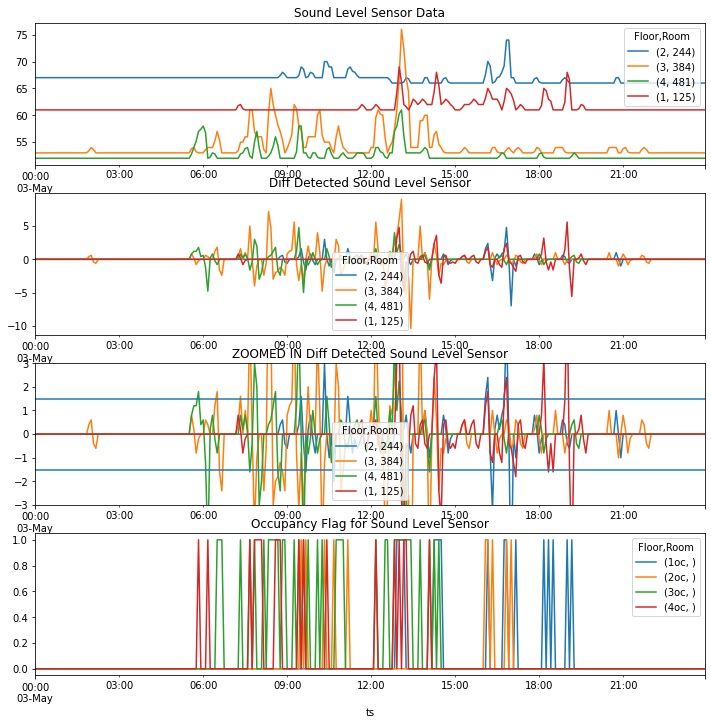

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1)
soledf['2021-05-03'].plot(ax=axes[0],figsize=(12,12)); 
axes[0].set_title('Sound Level Sensor Data')
floordiff['2021-05-03'].iloc[:,0:4].plot(ax=axes[1]); 
axes[1].set_title('Diff Detected Sound Level Sensor')
floordiff['2021-05-03'].iloc[:,0:4].plot(ax=axes[2]); 
axes[2].set_title('ZOOMED IN Diff Detected Sound Level Sensor')
axes[2].set_ylim(-3,3); axes[2].axhline(1.5); axes[2].axhline(-1.5)
floordiff['2021-05-03'].iloc[:,4:8].plot(ax=axes[3]); 
axes[3].set_title('Occupancy Flag for Sound Level Sensor')

In [ ]:
soocdf = floordiff.iloc[:,4:8]
soocdf

Floor,1oc,2oc,3oc,4oc
Room,,,,
ts,,,,
2020-12-21 10:50:00-08:00,0,0,0,0
2020-12-21 10:55:00-08:00,1,1,1,1
2020-12-21 11:00:00-08:00,0,1,0,1
2020-12-21 11:05:00-08:00,1,1,0,1
2020-12-21 11:10:00-08:00,1,1,1,1
...,...,...,...,...
2021-05-07 09:00:00-07:00,0,0,0,0
2021-05-07 09:05:00-07:00,0,0,0,0


In [ ]:
soocdf.to_csv(path_or_buf = drive_path + 'modelData/' + 'soundLevelSensor_occ.csv')